In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
reset -fs

In [1]:
!/usr/bin/python3 -m pip install "pymongo[srv]"

ERROR: Operation cancelled by user


In [2]:
exit()

In [1]:
! pip install isodate

     |████████████████████████████████| 41 kB 547 kB/s 


In [2]:
! pip install spacy-langdetect

     |████████████████████████████████| 998 kB 8.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993430 sha256=4aa37da6111617d212141695ee0c3893990696960ef715e3a05256eab04f66ab
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import pymongo
from pymongo import MongoClient
import isodate
import datetime as dt
import pickle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [5]:
import re
import spacy
from spacy.symbols import amod
from spacy.language import Language
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text   import Tokenizer
from tensorflow.keras.preprocessing        import sequence
#from tensorflow.keras.optimizers           import SGD, RMSprop

In [7]:
connection_string = "*******************************************"
client = MongoClient(connection_string)

In [8]:
client.list_database_names()

['youtube', 'admin', 'local']

In [9]:
videos = client.youtube.videos
channels = client.youtube.channels

In [10]:
video_mongo = list(videos.find({}, {'_id':0, 'id':1, 'timestamp': 1, 
                                    'snippet': {'publishedAt': 1, 'channelId':1, 'title': 1, 'description': 1, 'channelTitle': 1, 'tags': 1, 'categoryId': 1}, 
                                    'contentDetails': {'caption': 1, 'definition': 1, 'dimension': 1, 'duration': 1, 'projection': 1},
                                    'statistics': {'viewCount': 1},
                                    'status': {'embeddable': 1, 'license': 1, 'madeForKids': 1}}))

In [11]:
df_video = pd.json_normalize(video_mongo)
df_video['snippet.tags'] = df_video['snippet.tags'].fillna('[]')

In [12]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38221 entries, 0 to 38220
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         38221 non-null  object
 1   timestamp                  38221 non-null  object
 2   snippet.publishedAt        38221 non-null  object
 3   snippet.channelId          38221 non-null  object
 4   snippet.title              38221 non-null  object
 5   snippet.description        38221 non-null  object
 6   snippet.channelTitle       38221 non-null  object
 7   snippet.tags               38221 non-null  object
 8   snippet.categoryId         38221 non-null  object
 9   contentDetails.duration    38221 non-null  object
 10  contentDetails.dimension   38221 non-null  object
 11  contentDetails.definition  38221 non-null  object
 12  contentDetails.caption     38221 non-null  object
 13  contentDetails.projection  38221 non-null  object
 14  status

In [13]:
df_video.dropna(how='any', inplace=True)
df_video.drop_duplicates(subset = 'id', inplace=True, keep='last')
df_video['title_nlp'] = df_video['snippet.title'].map(lambda x:nlp(x))
df_video['language'] = df_video['title_nlp'].map(lambda x: x._.language['language'])
df_video = df_video[df_video['language'] == 'en']
df_video['status.madeForKids'] = df_video['status.madeForKids'].astype(int)#madeForKids: 2%
df_video['status.embeddable'] = df_video['status.embeddable'].astype(int) #embeddable: 1%
df_video['statistics.viewCount'] = df_video['statistics.viewCount'].astype(int)
df_video['contentDetails.duration'] = df_video['contentDetails.duration'].map(lambda x: int(isodate.parse_duration(x).total_seconds())) #isodate new library
df_video['2d'] = (df_video['contentDetails.dimension'] == '2d').astype(int) #2d 100%
df_video['hd'] = (df_video['contentDetails.definition'] == 'hd').astype(int) #hd 86%
df_video['rectangular'] = (df_video['contentDetails.projection'] == 'rectangular').astype(int) #rectangular 99.9%
df_video['timestamp'] = pd.to_datetime(df_video['timestamp'], utc=True)
df_video['snippet.publishedAt'] = pd.to_datetime(df_video['snippet.publishedAt'])
df_video['video_publish_sec'] = (df_video['timestamp'] - df_video['snippet.publishedAt']).dt.total_seconds().astype(int)
df_video = pd.get_dummies(df_video, columns=['snippet.categoryId'], drop_first=False)
df_video.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [14]:
#nlp clean
df_video['description_nlp'] = df_video['snippet.description'].map(lambda x:nlp(x))
df_video['tags_nlp'] = df_video['snippet.tags'].map(lambda x: ' '.join(x)).map(lambda x:nlp(x))
df_video['title_clean'] = df_video['title_nlp'].map(lambda x: [[w.lemma_.lower() for w in x if 
                                                               (not w.is_stop and not w.is_punct and not w.like_num) or (w.lemma_=='not')]])
df_video['title_clean'] = df_video['title_clean'].map(lambda x: ' '.join(x[0])).map(lambda x: x.replace('\n',''))
df_video['description_clean'] = df_video['description_nlp'].map(lambda x: [[w.lemma_.lower() for w in x if 
                                                                           (not w.is_stop and not w.is_punct and not w.like_num) or (w.lemma_=='not')]])
df_video['description_clean'] = df_video['description_clean'].map(lambda x: ' '.join(x[0])).map(lambda x: x.replace('\n',''))
df_video['tags_clean'] = df_video['tags_nlp'].map(lambda x: [[w.lemma_.lower() for w in x if 
                                                                           (not w.is_stop and not w.is_punct and not w.like_num) or (w.lemma_=='not')]])
df_video['tags_clean'] = df_video['tags_clean'].map(lambda x: ' '.join(x[0])).map(lambda x: x.replace('\n',''))

In [15]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10869 entries, 0 to 10868
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   id                         10869 non-null  object             
 1   timestamp                  10869 non-null  datetime64[ns, UTC]
 2   snippet.publishedAt        10869 non-null  datetime64[ns, UTC]
 3   snippet.channelId          10869 non-null  object             
 4   snippet.title              10869 non-null  object             
 5   snippet.description        10869 non-null  object             
 6   snippet.channelTitle       10869 non-null  object             
 7   snippet.tags               10869 non-null  object             
 8   contentDetails.duration    10869 non-null  int64              
 9   contentDetails.dimension   10869 non-null  object             
 10  contentDetails.definition  10869 non-null  object             
 11  co

In [16]:
channel_mongo = list(channels.find({}, {'_id':0, 'id':1, 'timestamp': 1, 
                                        'snippet': {'title': 1, 'publishedAt': 1, 'country': 1}, #'description': 1,
                                        'statistics': {'subscriberCount':1, 'hiddenSubscriberCount':1, 'videoCount': 1}, #'viewCount': 1, 
                                        'status': {'madeForKids': 1}})) #'privacyStatus': 1,

In [17]:
df_channel = pd.json_normalize(channel_mongo)
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20056 entries, 0 to 20055
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   id                                20056 non-null  object
 1   timestamp                         20056 non-null  object
 2   snippet.title                     20056 non-null  object
 3   snippet.publishedAt               20056 non-null  object
 4   snippet.country                   16447 non-null  object
 5   statistics.subscriberCount        19275 non-null  object
 6   statistics.hiddenSubscriberCount  20056 non-null  bool  
 7   statistics.videoCount             20056 non-null  object
 8   status.madeForKids                14685 non-null  object
dtypes: bool(1), object(8)
memory usage: 1.2+ MB


In [18]:
df_channel['status.madeForKids'] = df_channel['status.madeForKids'].fillna(False)
df_channel.dropna(subset= ['statistics.subscriberCount'], inplace=True) #consider to fill by other numbers later
df_channel.drop_duplicates(subset = 'id', inplace=True, keep='last')
df_channel['statistics.subscriberCount'] = df_channel['statistics.subscriberCount'].astype(int)
df_channel['status.madeForKids'] = df_channel['status.madeForKids'].astype(int)#madeForKids: 1.5%
df_channel['statistics.videoCount'] = df_channel['statistics.videoCount'].astype(int)
df_channel['US'] = (df_channel['snippet.country'] == 'US').astype(int) #42%
df_channel['IN'] = (df_channel['snippet.country'] == 'IN').astype(int) #17%
df_channel['GB'] = (df_channel['snippet.country'] == 'GB').astype(int) #8%
df_channel['CA'] = (df_channel['snippet.country'] == 'CA').astype(int) #4%
df_channel['AU'] = (df_channel['snippet.country'] == 'AU').astype(int) #3%
df_channel['timestamp'] = pd.to_datetime(df_channel['timestamp'], utc=True)
df_channel['snippet.publishedAt'] = pd.to_datetime(df_channel['snippet.publishedAt'])
df_channel['channel_publish_sec'] = (df_channel['timestamp'] - df_channel['snippet.publishedAt']).dt.total_seconds().astype(int)

In [19]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6553 entries, 4 to 20055
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   id                                6553 non-null   object             
 1   timestamp                         6553 non-null   datetime64[ns, UTC]
 2   snippet.title                     6553 non-null   object             
 3   snippet.publishedAt               6553 non-null   datetime64[ns, UTC]
 4   snippet.country                   5402 non-null   object             
 5   statistics.subscriberCount        6553 non-null   int64              
 6   statistics.hiddenSubscriberCount  6553 non-null   bool               
 7   statistics.videoCount             6553 non-null   int64              
 8   status.madeForKids                6553 non-null   int64              
 9   US                                6553 non-null   int64       

In [20]:
df = df_video.merge(df_channel, left_on='snippet.channelId', right_on='id')
df['daily_view'] = (df['statistics.viewCount'] / df['video_publish_sec'] * 60 * 60 * 24).astype('int')
df['statistics.viewCount'][df['statistics.viewCount']==0] = 1
df['total_view_log10'] = np.log10(df['statistics.viewCount'])
df['daily_view'][df['daily_view']==0] = 1
df['daily_view_log10'] = np.log10(df['daily_view'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10472 entries, 0 to 10471
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   contentDetails.duration     10472 non-null  int64  
 1   status.madeForKids_x        10472 non-null  int64  
 2   hd                          10472 non-null  int64  
 3   rectangular                 10472 non-null  int64  
 4   snippet.categoryId_1        10472 non-null  uint8  
 5   snippet.categoryId_10       10472 non-null  uint8  
 6   snippet.categoryId_17       10472 non-null  uint8  
 7   snippet.categoryId_19       10472 non-null  uint8  
 8   snippet.categoryId_2        10472 non-null  uint8  
 9   snippet.categoryId_20       10472 non-null  uint8  
 10  snippet.categoryId_22       10472 non-null  uint8  
 11  snippet.categoryId_23       10472 non-null  uint8  
 12  snippet.categoryId_24       10472 non-null  uint8  
 13  snippet.categoryId_25       104

In [30]:
#save df
df_save = df[['contentDetails.duration', 'status.madeForKids_x', 'hd','rectangular', 'snippet.categoryId_1', 
               'snippet.categoryId_10', 'snippet.categoryId_17', 'snippet.categoryId_19', 'snippet.categoryId_2', 
               'snippet.categoryId_20', 'snippet.categoryId_22', 'snippet.categoryId_23', 'snippet.categoryId_24', 
               'snippet.categoryId_25', 'snippet.categoryId_26', 'snippet.categoryId_27', 'snippet.categoryId_28', 
               'snippet.categoryId_29', 'statistics.subscriberCount', 'statistics.videoCount', 'status.madeForKids_y', 
               'US', 'IN', 'GB', 'CA', 'AU', 'channel_publish_sec', 'title_clean', 'description_clean', 'tags_clean',
               'id_x', 'statistics.viewCount', 'video_publish_sec', 'daily_view', 'total_view_log10', 'daily_view_log10']]

with open('/content/drive/MyDrive/youtube_model/df_1215.pkl', 'wb') as f:
    pickle.dump(df_save, f)


In [7]:
#load
with open('/content/drive/MyDrive/youtube_model/df_1215.pkl', 'rb') as f:
    df = pickle.load(f)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10472 entries, 0 to 10471
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   contentDetails.duration     10472 non-null  int64  
 1   status.madeForKids_x        10472 non-null  int64  
 2   hd                          10472 non-null  int64  
 3   rectangular                 10472 non-null  int64  
 4   snippet.categoryId_1        10472 non-null  uint8  
 5   snippet.categoryId_10       10472 non-null  uint8  
 6   snippet.categoryId_17       10472 non-null  uint8  
 7   snippet.categoryId_19       10472 non-null  uint8  
 8   snippet.categoryId_2        10472 non-null  uint8  
 9   snippet.categoryId_20       10472 non-null  uint8  
 10  snippet.categoryId_22       10472 non-null  uint8  
 11  snippet.categoryId_23       10472 non-null  uint8  
 12  snippet.categoryId_24       10472 non-null  uint8  
 13  snippet.categoryId_25       104

In [9]:
#holdout test data
df_train, df_test= train_test_split(df, test_size=0.2, random_state=11)

In [10]:
#training data and validation data
df_train, df_val= train_test_split(df_train, test_size=0.25, random_state=11)

In [11]:
print(len(df_train), len(df_val), len(df_test))
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

6282 2095 2095


In [12]:
#daily
features = ['contentDetails.duration', 'status.madeForKids_x', 'hd','rectangular', 'snippet.categoryId_1', 'snippet.categoryId_10', 
            'snippet.categoryId_17', 'snippet.categoryId_19', 'snippet.categoryId_2', 'snippet.categoryId_20', 'snippet.categoryId_22', 'snippet.categoryId_23',
            'snippet.categoryId_24', 'snippet.categoryId_25', 'snippet.categoryId_26', 'snippet.categoryId_27', 'snippet.categoryId_28', 'snippet.categoryId_29', 
            'statistics.subscriberCount', 'statistics.videoCount', 'status.madeForKids_y', 'US', 'IN', 'GB', 'CA', 'AU', 'channel_publish_sec']
label = ['daily_view_log10']

In [13]:
scaler = StandardScaler()
X_fea_train = scaler.fit_transform(df_train[features])
X_fea_val = scaler.transform(df_val[features])

with open('/content/drive/MyDrive/youtube_model/feature_scaler_1216_log_daily_view.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [ ]:
#run if needed to download new thumbnails
def get_thumbnail(video_id_list):
    count = 0
    for v in video_id_list:
        thumbnail = requests.get(f'https://i.ytimg.com/vi/{v}/mqdefault.jpg').content
        with open(f'/content/drive/MyDrive/thumbnails/{v}.jpg', 'wb') as f:
            f.write(thumbnail)
        #time.sleep(np.random.uniform(1, 3))
        count += 1
        if count % 100 == 0:
            print(f'{count} done')
    print('thumbnails done!')
    pass

import requests
import os
all_video_id = videos.distinct('id')
old_video_id = os.listdir("/content/drive/MyDrive/thumbnails/")
old_video_id = [x[:-4] for x in old_video_id]
list_difference = list(set(all_video_id) - set(old_video_id))
get_thumbnail(list_difference)


In [ ]:
# copy to google colab may speed up
%cp -av "/content/drive/MyDrive/thumbnails" "/content/sample_data"

In [14]:
#faster! but still ram issue
images = []
for i in df_train.id_x:
    with open(f'drive/MyDrive/thumbnails/{i}.jpg', 'rb') as f:
        img = Image.open(f).convert('RGB').resize((224,224))
        img_data = np.array(img)
    images.append(img_data)
images = np.array(images)/255
print("first step done")
images = tf.convert_to_tensor(images, dtype=tf.float32)


first step done


In [15]:
val_images = []
for i in df_val.id_x:
    with open(f'drive/MyDrive/thumbnails/{i}.jpg', 'rb') as f:
        img = Image.open(f).convert('RGB').resize((224,224))
        img_data = np.array(img)
    val_images.append(img_data)
val_images = np.array(val_images)/255
print("first step done")
val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)

first step done


In [ ]:
#slow
"""
val_images = []
for i in df_val.id_x:
    with open(f'drive/MyDrive/thumbnails/{i}.jpg', 'rb') as f:
        img = Image.open(f).convert('RGB').resize((224,224))
        img_data = np.array(img)/255#.astype(np.float32)#.reshape(-1,)
    val_images.append(img_data)
print("first step done")
val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)
"""

In [37]:
test_images = []
for i in df_test.id_x:
    with open(f'drive/MyDrive/thumbnails/{i}.jpg', 'rb') as f:
        img = Image.open(f).convert('RGB').resize((224,224))
        img_data = np.array(img)
    test_images.append(img_data)
test_images = np.array(test_images)/255
print("first step done")
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

first step done


In [16]:
title_maxlen = df_train.title_clean.map(lambda x:len(x.split())).max()
print('title_maxlen: ', title_maxlen)
title_num_words = 10000
title_tokenizer = Tokenizer(num_words=title_num_words)
title_tokenizer.fit_on_texts(df_train.title_clean)
train_title = title_tokenizer.texts_to_sequences(df_train.title_clean) 
train_title = sequence.pad_sequences(train_title, maxlen=title_maxlen)

val_title = title_tokenizer.texts_to_sequences(df_val.title_clean)
val_title = sequence.pad_sequences(val_title, maxlen=title_maxlen)
with open('/content/drive/MyDrive/youtube_model/title_tokenizer_1215.pkl', 'wb') as f:
    pickle.dump(title_tokenizer, f)

title_maxlen:  22


In [17]:
tag_maxlen = df_train.tags_clean.map(lambda x:len(x.split())).max()
print('tag_maxlen: ', tag_maxlen)
tag_num_words = 5000
tag_tokenizer = Tokenizer(num_words=tag_num_words)
tag_tokenizer.fit_on_texts(df_train.tags_clean)
train_tag = tag_tokenizer.texts_to_sequences(df_train.tags_clean) 
train_tag = sequence.pad_sequences(train_tag, maxlen=tag_maxlen)

val_tag = tag_tokenizer.texts_to_sequences(df_val.tags_clean)
val_tag = sequence.pad_sequences(val_tag, maxlen=tag_maxlen)
with open('/content/drive/MyDrive/youtube_model/tag_tokenizer_1215.pkl', 'wb') as f:
    pickle.dump(tag_tokenizer, f)

tag_maxlen:  105


In [18]:
des_maxlen = df_train.description_clean.map(lambda x:len(x.split())).max()
print('des_maxlen: ', des_maxlen)
des_num_words = 20000
des_tokenizer = Tokenizer(num_words=des_num_words)
des_tokenizer.fit_on_texts(df_train.description_clean)
train_des = des_tokenizer.texts_to_sequences(df_train.description_clean) 
train_des = sequence.pad_sequences(train_des, maxlen=des_maxlen)

val_des = des_tokenizer.texts_to_sequences(df_val.description_clean)
val_des = sequence.pad_sequences(val_des, maxlen=des_maxlen)
with open('/content/drive/MyDrive/youtube_model/des_tokenizer_1215.pkl', 'wb') as f:
    pickle.dump(des_tokenizer, f)

des_maxlen:  765


In [ ]:
#slice apporch
def generator(data, fea, title, tag, des, batch_size=32, resize=224):
    sample_size = len(data)
    i = 0
    while True:
        for _ in range(sample_size//batch_size + 1):
            video_id = data.id_x[i:i+batch_size]
            images = []
            for i in video_id:
                with open(f'drive/MyDrive/thumbnails/{i}.jpg', 'rb') as f:
                    img = Image.open(f).convert('RGB').resize((resize,resize))
                    img_data = np.array(img)/255#.astype(np.float32)#.reshape(-1,)
                    images.append(img_data)
            images = tf.convert_to_tensor(images, dtype=tf.float32)

            X_combined = [
                        images,
                        np.array(fea[start:start+batch_size]), 
                        np.array(title[start:start+batch_size]), 
                        np.array(tag[start:start+batch_size]), 
                        np.array(des[start:start+batch_size])
            ]
            
            y = data['statistics.viewCount'][i:i+batch_size]
            i += batch_size
            yield X_combined, np.array(y)


In [ ]:
#one by one append approach
def generator(data, fea, title, tag, des, batch_size=32, resize=224):
    sample_size = len(data)
    i = 0
    y_o = data['statistics.viewCount']
    while True:
        images, fea_a, title_a, tag_a, des_a, y_a = [], [], [], [], [], []
        for _ in range(batch_size):
            if i == len(data):
                i = 0 #reset
            video_id = data.id_x[i]
            with open(f'drive/MyDrive/thumbnails/{video_id}.jpg', 'rb') as f:
                img = Image.open(f).convert('RGB').resize((resize,resize))
                img_data = np.array(img)/255#.astype(np.float32)#.reshape(-1,)
                images.append(img_data)
            fea_a.append(fea[i])
            title_a.append(title[i])
            tag_a.append(tag[i])
            des_a.append(des[i])
            y_a.append(y_o[i])
            i += 1

        X_combined = [
                    tf.convert_to_tensor(images, dtype=tf.float32),
                    np.array(fea_a), 
                    np.array(title_a), 
                    np.array(tag_a), 
                    np.array(des_a)
        ]
        

        yield X_combined, np.array(y_a)

In [ ]:
batch_size = 128
train_data = generator(df_train, X_fea_train, train_title, train_tag, train_des, batch_size=batch_size)
val_data = generator(df_val, X_fea_val, val_title, val_tag, val_des, batch_size=batch_size)

In [19]:
# define inputs
inputa = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
inputb = Input(shape=(len(features),))
inputc = Input(shape=(title_maxlen,))
inputd = Input(shape=(tag_maxlen,))
inpute = Input(shape=(des_maxlen,))

# image branch
for layer in inputa.layers:
    layer.trainable = False
a = inputa.output
a = Flatten()(a)
a = Dense(64, activation="relu")(a)
a = Model(inputs=inputa.input, outputs=a)

# features branch
b = Dense(32, activation="relu")(inputb)
b = Dense(64, activation="relu")(b)
#b = Dropout(0.05)(b)
#b = Dense(1024, activation="relu")(b)
b = Model(inputs=inputb, outputs=b)

# title branch
c = Embedding(input_dim=title_num_words, output_dim=64)(inputc)
c = Flatten()(c)
c = Dense(64, activation="relu")(c)
c = Model(inputs=inputc, outputs=c)

# tag branch
d = Embedding(input_dim=tag_num_words, output_dim=64)(inputd)
d = Flatten()(d)
d = Dense(64, activation="relu")(d)
d = Model(inputs=inputd, outputs=d)

# description branch
e = Embedding(input_dim=des_num_words, output_dim=64)(inpute)
e = Convolution1D(filters=16, kernel_size=5, activation='relu')(e)
e = MaxPooling1D()(e)
e = Bidirectional(LSTM(32, recurrent_dropout=.1))(e)
#e = Dense(512, activation="relu")(e)
e = Model(inputs=inpute, outputs=e)

# combined outputs
combined = concatenate([a.output, b.output, c.output, d.output, e.output])
x = Dense(128, activation="relu")(combined)
x = Dropout(0.05)(x)
x = Dense(64, activation="relu")(x)
#x = Dropout(0.05)(x)
#x = Dense(512, activation="relu")(x)
x = Dense(1, activation="linear")(x)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[a.input, b.input, c.input, d.input, e.input], outputs=x)
model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                             

# 5 branches with daily views as label

In [20]:
# load when crashed
model = keras.models.load_model('/content/drive/MyDrive/youtube_model/dl_1215_5m_100_daily.h5')

In [46]:
#5m
model.fit(x = [images, X_fea_train, train_title, train_tag, train_des], y = df_train[label], epochs = 1, verbose = 1, batch_size =32,
          validation_data = ([val_images, X_fea_val, val_title, val_tag, val_des], df_val[label]), 
          callbacks=[keras.callbacks.CSVLogger('training.log', separator=',', append=False),
                      keras.callbacks.EarlyStopping(patience=9, verbose=1, restore_best_weights=True),
                      keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])

197/197 [==============================] - 572s 3s/step - loss: 1.2672 - mean_absolute_error: 0.8456 - val_loss: 0.8048 - val_mean_absolute_error: 0.6767 - lr: 1.0000e-04


In [21]:
model.save("/content/drive/MyDrive/youtube_model/dl_1215_5m_100_log_daily.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
#2-21
model.fit(x = [images, X_fea_train, train_title, train_tag, train_des], y = np.array(df_train[label]), epochs = 20, verbose = 1, batch_size =32,
          validation_data = ([val_images, X_fea_val, val_title, val_tag, val_des], df_val[label]), 
          callbacks=[keras.callbacks.CSVLogger('training.log', separator=',', append=False),
                      keras.callbacks.EarlyStopping(patience=7, verbose=1, restore_best_weights=True),
                      keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])
model.save("/content/drive/MyDrive/youtube_model/dl_1215_5m_100_log_daily.h5")

Epoch 1/20
197/197 [==============================] - 384s 2s/step - loss: 2.7606 - mean_absolute_error: 1.3118 - val_loss: 1.8759 - val_mean_absolute_error: 1.1072 - lr: 1.0000e-04
Epoch 2/20
197/197 [==============================] - 360s 2s/step - loss: 1.5422 - mean_absolute_error: 0.9914 - val_loss: 1.9072 - val_mean_absolute_error: 1.1268 - lr: 1.0000e-04
Epoch 3/20
197/197 [==============================] - 360s 2s/step - loss: 0.8663 - mean_absolute_error: 0.7279 - val_loss: 1.6599 - val_mean_absolute_error: 1.0132 - lr: 1.0000e-04
Epoch 4/20
197/197 [==============================] - 362s 2s/step - loss: 0.4528 - mean_absolute_error: 0.5255 - val_loss: 1.6271 - val_mean_absolute_error: 0.9777 - lr: 1.0000e-04
Epoch 5/20
197/197 [==============================] - 363s 2s/step - loss: 0.2779 - mean_absolute_error: 0.4115 - val_loss: 1.5830 - val_mean_absolute_error: 0.9640 - lr: 1.0000e-04
Epoch 6/20
  8/197 [>.............................] - ETA: 5:33 - loss: 0.2195 - mean_abso

KeyboardInterrupt: ignored

In [34]:
#22-81
model.fit(x = [images, X_fea_train, train_title, train_tag, train_des], y = df_train[label] , epochs = 60, verbose = 1, batch_size =32,
          validation_data = ([val_images, X_fea_val, val_title, val_tag, val_des], df_val[label]), 
          callbacks=[keras.callbacks.CSVLogger('training.log', separator=',', append=False),
                      keras.callbacks.EarlyStopping(patience=7, verbose=1, restore_best_weights=True),
                      keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])
model.save("/content/drive/MyDrive/youtube_model/dl_1215_5m_100_log_daily.h5")

Epoch 1/60
197/197 [==============================] - 367s 2s/step - loss: 0.1921 - mean_absolute_error: 0.3454 - val_loss: 1.5924 - val_mean_absolute_error: 0.9807 - lr: 1.0000e-04
Epoch 2/60
197/197 [==============================] - 360s 2s/step - loss: 0.1520 - mean_absolute_error: 0.3041 - val_loss: 1.5185 - val_mean_absolute_error: 0.9525 - lr: 1.0000e-04
Epoch 3/60
197/197 [==============================] - 360s 2s/step - loss: 0.1394 - mean_absolute_error: 0.2933 - val_loss: 1.5577 - val_mean_absolute_error: 0.9661 - lr: 1.0000e-04
Epoch 4/60
197/197 [==============================] - 359s 2s/step - loss: 0.1242 - mean_absolute_error: 0.2752 - val_loss: 1.5047 - val_mean_absolute_error: 0.9505 - lr: 1.0000e-04
Epoch 5/60
197/197 [==============================] - 360s 2s/step - loss: 0.1188 - mean_absolute_error: 0.2681 - val_loss: 1.4846 - val_mean_absolute_error: 0.9441 - lr: 1.0000e-04
Epoch 6/60
197/197 [==============================] - 358s 2s/step - loss: 0.1160 - mean_a

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


(array([6.208e+03, 4.800e+01, 1.700e+01, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([       0. ,  2233543.1,  4467086.2,  6700629.3,  8934172.4,
        11167715.5, 13401258.6, 15634801.7, 17868344.8, 20101887.9,
        22335431. ]),
 <a list of 10 Patch objects>)

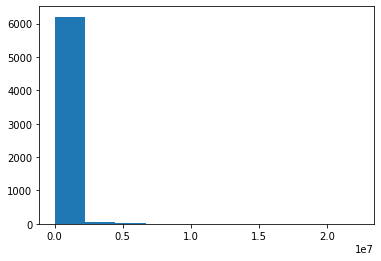

In [42]:
#daily_view
plt.hist(np.array(df_train['daily_view']))

(array([ 104.,  247.,  740.,  317.,  141.,  631., 2170., 1596.,  305.,
          31.]),
 array([0.        , 0.73489943, 1.46979887, 2.2046983 , 2.93959773,
        3.67449717, 4.4093966 , 5.14429604, 5.87919547, 6.6140949 ,
        7.34899434]),
 <a list of 10 Patch objects>)

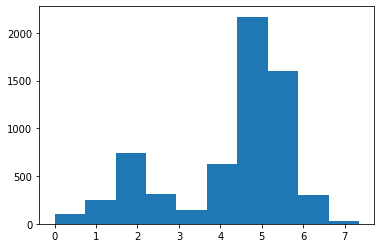

In [72]:
#daily_view
plt.hist(np.log10(np.array(df_train['daily_view'])))

In [36]:
model.evaluate(x=[val_images, X_fea_val, val_title, val_tag, val_des], y=df_val[label])

66/66 [==============================] - 12s 178ms/step - loss: 1.0754 - mean_absolute_error: 0.7867


[1.0754307508468628, 0.786687433719635]

In [38]:
X_fea_test = scaler.transform(df_test[features])
test_title = title_tokenizer.texts_to_sequences(df_test.title_clean)
test_title = sequence.pad_sequences(test_title, maxlen=title_maxlen)
test_tag = tag_tokenizer.texts_to_sequences(df_test.tags_clean)
test_tag = sequence.pad_sequences(test_tag, maxlen=tag_maxlen)
test_des = des_tokenizer.texts_to_sequences(df_test.description_clean) 
test_des = sequence.pad_sequences(test_des, maxlen=des_maxlen)

In [39]:
model.evaluate(x=[test_images, X_fea_test, test_title, test_tag, test_des], y=df_test[label])

66/66 [==============================] - 12s 181ms/step - loss: 1.0808 - mean_absolute_error: 0.7796


[1.0808371305465698, 0.7796258330345154]

In [40]:
test_pred = model.predict(x=[test_images, X_fea_test, test_title, test_tag, test_des])

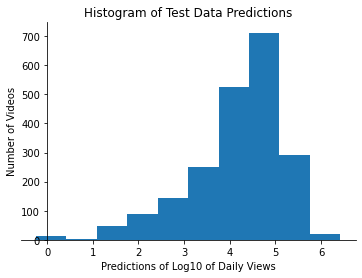

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.hist(test_pred)
plt.title('Histogram of Test Data Predictions')
plt.xlabel('Predictions of Log10 of Daily Views')
plt.ylabel('Number of Videos')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.savefig("test_prediciton_hist.png", dpi = 400, facecolor = "w", bbox_inches="tight");